# Creating a BaseModel

In [1]:
from pathlib import Path
from typing import List, Tuple, Union, Set
import glob

import pandas as pd
import numpy as np

import shutil          # provides high level file operations
import time            # used to measure execution time
import os
import sys

from pyspark.sql.functions import col

In [51]:
trainingset_folder    = "D:/data_mt/09_training/"
stock_data_folder = trainingset_folder + "stocks/"
combine_data_folder = trainingset_folder + "combined/"

combined_data_file = trainingset_folder + "/all_combine_data"

model_folder = "D:/data_mt/10_models/"


## 01_Tools

In [3]:
def load_additional_info() -> pd.DataFrame:
    return pd.read_csv(trainingset_folder + "company_info.csv", sep=',', encoding='utf-8', header=0)

In [4]:
def load_stock_history(ticker:str):
    df =  pd.read_csv(combine_data_folder + ticker[0] + "/" + ticker + ".csv")
    df.Date = pd.to_datetime(df.Date)
    return df

In [5]:
import findspark
from pyspark.sql import SparkSession
def get_spark_session(appname = "default"):
    """
    Initialises a spark session. 
    Parameters:
    appname - default is "default"
    """
    findspark.init()
    return SparkSession.builder \
                        .appName(appname) \
                        .getOrCreate()

In [6]:
# init Spark
spark = get_spark_session() # Session anlegen
spark # display the moste important information of the session

## 02_Load Data

In [23]:
df_all = spark.read.parquet(combined_data_file)
df_all.count()

4365181

In [25]:
add_info = load_additional_info()

## 03_Build Train and Testdata

In [26]:
features = ['r_workcapToAssets', 'r_currentRatio', 'r_deptToEquity', 'r_deptRatio', 'r_netProfitMargin', 'r_operatingMargin', 'r_netIncomeMargin', 
            'r_cashGenPowerRatio', 'r_extFinancingIndexRatio', 'r_returnOnEquity', 'r_returnOnAssets', 'r_assetsTurnoverRatio', 'r_dividendPayoutRatio', 
            'r_stockRepurchaseRatio', 'r_operatingCashFlowRatio', 'r_assetEfficiencyRatio', 'r_currentLiabCoverageRatio', 'r_longtermDeptCoverageRatio',
            'gr_revenue_n', 'gr_revenue_p', 'gr_grosspr_n', 'gr_grosspr_p', 'gr_opiincome_n', 'gr_opiincome_p', 'gr_netincome_n', 'gr_netincome_p', 
            'gr_earnings_n', 'gr_earnings_p', 'gr_equity_n', 'gr_equity_p', 'gr_asscur_n', 'gr_asscur_p', 'gr_assnoncur_n', 'gr_assnoncur_p', 
            'gr_liabcur_n', 'gr_liabcur_p', 'gr_liabnoncur_n', 'gr_liabnoncur_p', 'gr_cashfrominv_n', 'gr_cashfrominv_p', 
            'gr_cashfromfin_n', 'gr_cashfromfin_p', 'gr_cashfromope_n', 'gr_cashfromope_p', 'gr_dividends_n', 'gr_dividends_p',
            'fp__FY', 'fp__Q1', 'fp__Q2', 'fp__Q3', 'fp__Q4',
            'close_norm', 'high_norm', 'low_norm', 'open_norm', 'volume_norm', 'close_chg', 'volume_chg', 
            'day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month_of_year', 
            'pr_p2e', 'pr_p2b', 'pr_p2egr_1y'       
           ]

label =    'r_potential'

all_cols = list(features)
all_cols.append(label)

In [27]:
filter_no_potential = "r_potential > -1.0" 

In [93]:
top_30 = add_info[add_info.mc_top30 == 1].ticker.to_list()
top_50 = add_info[add_info.mc_top50 == 1].ticker.to_list()
top_100 = add_info[add_info.mc_top100 == 1].ticker.to_list()
top_1000 = add_info[add_info.mc_top100 == 1].ticker.to_list()

### as a first test, create a test / training set only of the top 30 market capt in the dataset

In [29]:
df_train_test = df_all.where(col('ticker').isin(top_30)) \
                      .where(filter_no_potential) \
                      .select(all_cols)

In [41]:
df_train_test.count()

64910

In [42]:
# define what the label column is
df_train_test = df_train_test.withColumn("label", col('r_potential'))

## 04 Train Model
Follow https://www.silect.is/blog/random-forest-models-in-spark-ml/

In [43]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

assembler = VectorAssembler(inputCols=features, outputCol="features")

rf = RandomForestRegressor(labelCol="label", featuresCol="features")

pipeline = Pipeline(stages=[assembler, rf])

In [126]:
from pyspark.ml.tuning import ParamGridBuilder

# a first test showed that numOfTrees with 50 and max depth of 25 was a good starting point
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50]) \
    .addGrid(rf.maxDepth, [25]) \
    .build()

In [127]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [46]:
(trainingData, testData) = df_train_test.randomSplit([0.8, 0.2])

In [47]:
cvModel = crossval.fit(trainingData)

In [ ]:
# save Model for further reference
pip_model = cvModel.bestModel
pip_model.write().overwrite().save(model_folder + "model_01")

In [ ]:
print('numTrees - ', pip_model.getNumTrees)
print('maxDepth - ', pip_model.getOrDefault('maxDepth'))

## 05 Test and an do some primary analysis

### check predictions

In [48]:
predictions = cvModel.transform(testData)

In [ ]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Model Performance RMSE: %f" % rmse)

In [ ]:
# predict on train and test data
rfPred = cvModel.transform(df_train_test)
rfResult = rfPred.toPandas()

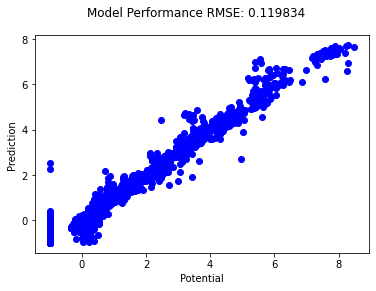

In [50]:
import matplotlib.pyplot as plt

plt.plot(rfResult.label, rfResult.prediction, 'bo')

plt.xlabel('Potential')
plt.ylabel('Prediction')

plt.show()

It is almost to good to be true how well the model fits the data. Buy we may not forget, that 80% of the data that is shown in the chart above was the trainingdata. Moreover, due to the characteristics of the data the testdata set is also very "similar" to the training data. We can make the argument that all of the shown datapoints were seen during training. But what we would be intersted in knowing how the model works with unseen data.

Therefore, the chart above isn't really meaningful. It only tells us, that the pipeline in general worked.

### Feature Importance

Text(0.5, 1.0, 'Feature Importances')

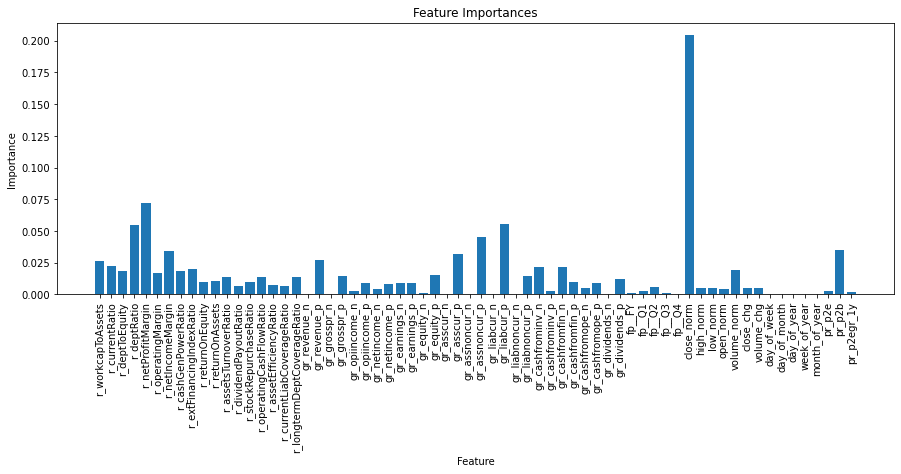

In [62]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]
importances = bestModel.featureImportances
x_values = list(range(len(importances)))

f, ax = plt.subplots(figsize=(15,5))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, features, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

What can be clearly seen is that "close_norm" ist the most importang feature. "close_norm" is simply the daily "close"-price normalized based on the last Closed Price in the data. The stockprice tends to grow over time (at least in the mean), that means generally at the end of of the data the value will be closer to 1.0. So "close_norm" kinda knows what kind of potential is left. Therefore, it is not a good idea that this feature is taken into consideration.

Moreover, also high_norm, low_norm or open_norm do really proved value.

It is interesting to see, that deptRatio, netProfitMargin and netIcnomeMargin are rather important features. This makes sense, since these are important number an investor looks into. The same is true for revenue growth (gr_revenue_p), current assets growth (gr_asscur_p), non current assets growth (gr_assnoncur_p) and current liabilities growth (gr_liabcur) are important, since they give a hint on how well a company is generating cash. 
Also the importance of the price to pook ratio (pr_p2b) makes sense, since this tells us how much a company is worth at the moment for every dollar of the stockprice.

## 06_Test on unseen data

As mentioned above in the previous chart we basically one made prediction on trainingdata, which of course, looks exceptionally well. But the real question is how good it is on unseen data.

The model was trainined on the data of the 30 companies with the biggest market capitalization. Now we will create a test set with the companies ranking 31 to 100 in market capitalization.

In [114]:
top_30_to_100 = set(top_100) - set(top_30)
df_30_100 = df_all.where(col('ticker').isin(top_30_to_100)) \
                 .where(filter_no_potential) \
                 .select(all_cols)
df_30_100.count()

140844

In [116]:
# for some reason there is a data point which has a null value somewhere.. so we make sure that there are no null values
df_30_100 = df_30_100.na.drop(how="any")
df_30_100.count()

140843

In [117]:
rfPred = cvModel.transform(df_30_100)
rfResult = rfPred.toPandas()

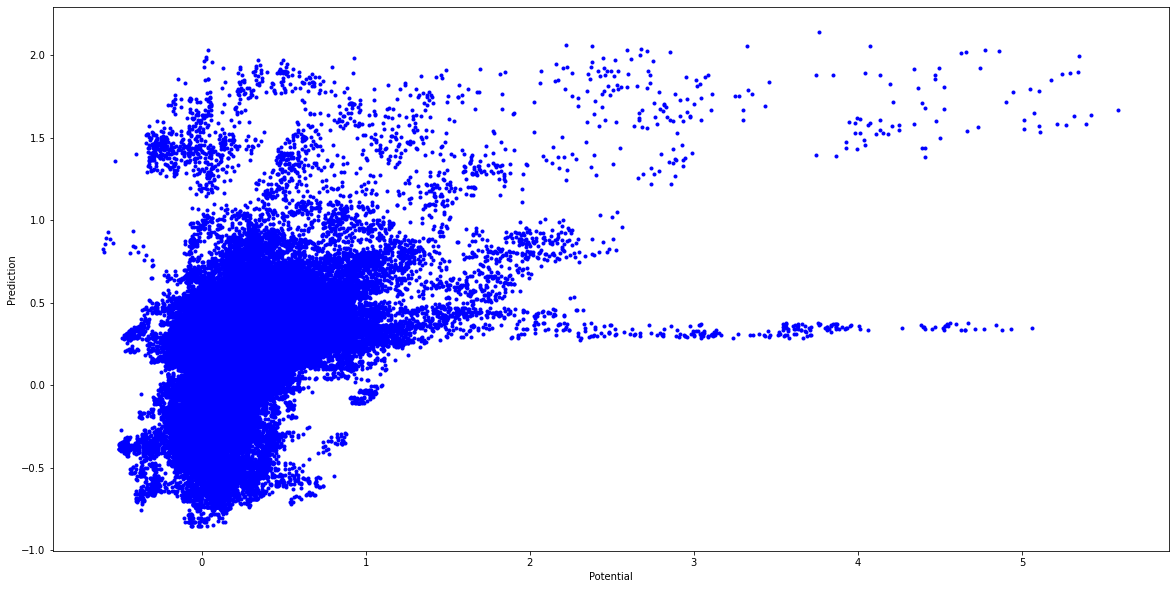

In [136]:
f, ax = plt.subplots(figsize=(20,10))

plt.plot(rfResult.r_potential, rfResult.prediction,'b.')

plt.xlabel('Potential')
plt.ylabel('Prediction')

plt.show()

This doesn't look too bad: points with a higher prediction seem to have had a higher real potential.
Let's have a deeper look and look only at datapoints which had a prediction of > .5

In [131]:
pointsAbovePred50 = rfResult[rfResult.prediction > 0.5].shape[0]
pointsAbovePred50WithLower0Pot = rfResult[(rfResult.prediction > 0.5) & (rfResult.r_potential < 0)].shape[0]

print("Number of times predicted above 50%: ", pointsAbovePred50)       
print("Number of those with a return < 0% : ", pointsAbovePred50WithLower0Pot)
print(" ... as percentage                 : ", 100 *pointsAbovePred50WithLower0Pot / pointsAbovePred50)

Number of times predicted above 50%:  11548
Number of those with a return < 0% :  848
 ... as percentage                 :  7.343262902667129


there were 11548 times when a more than 50% gain within 6..12 month in the future were predicted. Only in 848 cases (about 7.3) was the real return after 6..12 month less than 0%.

In [132]:
pot_pred_over50 = rfResult[rfResult.prediction > 0.5].r_potential
pot_pred_over50.describe()

count    11548.000000
mean         0.541555
std          0.596103
min         -0.599125
25%          0.203616
50%          0.388596
75%          0.735051
max          5.583756
Name: r_potential, dtype: float64

In fact, 50% of the datapoints acutally had a return of 39% or above, and 75% had a a return of at least 20% within less than a year.

<AxesSubplot:>

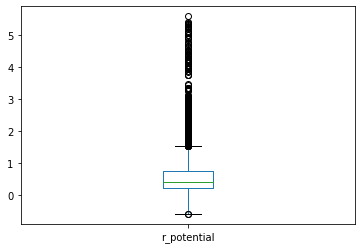

In [133]:
pot_pred_over50.plot.box()

In [137]:
rfResult.r_potential.describe()

count    140843.000000
mean          0.262351
std           0.311973
min          -0.599125
25%           0.096731
50%           0.213298
75%           0.357509
max           5.583756
Name: r_potential, dtype: float64

By just randomly picking an entry point, 50% of the datapoints had a return of 21%. which is significantly lower then the 39% from above (when only the datapoints were selected who had a prediction of 50% or more.

<AxesSubplot:>

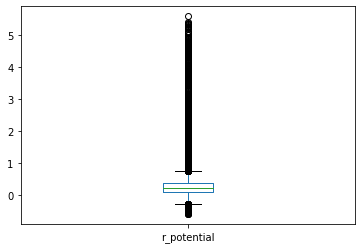

In [138]:
rfResult.r_potential.plot.box()

In [139]:
pointsAbovePred100 = rfResult[rfResult.prediction > 1.0].shape[0]
pointsAbovePred100WithLower0Pot = rfResult[(rfResult.prediction > 1.0) & (rfResult.r_potential < 0)].shape[0]

print("Number of times predicted above 100%: ", pointsAbovePred100)       
print("Number of those with a return < 0% : ", pointsAbovePred100WithLower0Pot)
print(" ... as percentage                 : ", 100 *pointsAbovePred100WithLower0Pot / pointsAbovePred100)

Number of times predicted above 100%:  1725
Number of those with a return < 0% :  333
 ... as percentage                 :  19.304347826086957


In [141]:
pot_pred_over100 = rfResult[rfResult.prediction > 1.00].r_potential
pot_pred_over100.describe()

count    1725.000000
mean        0.873336
std         1.116128
min        -0.525790
25%         0.058673
50%         0.573970
75%         1.283764
max         5.583756
Name: r_potential, dtype: float64

<AxesSubplot:>

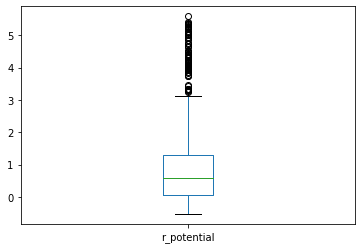

In [142]:
pot_pred_over100.plot.box()

features anpassen
- kein close_norm
- keine anderen stock werte
- keine day of..
- neue hinzuufügen sektor und evtl. industrie

# XX_Trials

In [10]:
aapl_df = load_stock_history("AAPL")

In [13]:
print(aapl_df.columns.to_list())

['cik', 'ticker_x', 'adsh', 'period', 'filed', 'form', 'bs_qtrs', 'fp', 'Assets', 'AssetsNoncurrent', 'AssetsCurrent', 'Liabilities', 'LiabilitiesNoncurrent', 'LiabilitiesCurrent', 'c_Equity', 'c_RetainedEarnings', 'cf_qtrs', 'c_CashIncreaseDecrease', 'c_CashFromOperating', 'c_CashFromInvesting', 'c_CashFromFinancing', 'c_PaymentsOfDividendsTotal', 'c_PaymentsForRepurchaseOfStockTotal', 'is_qtrs', 'c_Revenues', 'GrossProfit', 'c_OperatingIncomeLoss', 'c_NetIncomeLoss', 'period_day_of_week', 'period_day_of_month', 'period_day_of_year', 'period_week_of_year', 'period_month_of_year', 'r_workcapToAssets', 'r_currentRatio', 'r_deptToEquity', 'r_deptRatio', 'r_netProfitMargin', 'r_operatingMargin', 'r_netIncomeMargin', 'r_cashGenPowerRatio', 'r_extFinancingIndexRatio', 'r_returnOnEquity', 'r_returnOnAssets', 'r_assetsTurnoverRatio', 'r_dividendPayoutRatio', 'r_stockRepurchaseRatio', 'r_operatingCashFlowRatio', 'r_assetEfficiencyRatio', 'r_currentLiabCoverageRatio', 'r_longtermDeptCoverageRat

In [16]:
aapl_df

,cik,ticker_x,adsh,period,filed,form,bs_qtrs,fp,Assets,AssetsNoncurrent,...,day_of_month,day_of_year,week_of_year,month_of_year,ticker_y,pr_p2e,pr_p2b,pr_p2egr_1y,c_max_10day,r_potential
0,320193.0,AAPL,0001193125-12-182321,2012-03-31,2012-04-25,10-Q,0.0,Q2,1.509340e+11,1.002220e+11,...,0.806452,0.317808,0.326923,0.333333,AAPL,27.431174,3.110354,5.0,18.072315,-0.030499
1,320193.0,AAPL,0001193125-12-182321,2012-03-31,2012-04-25,10-Q,0.0,Q2,1.509340e+11,1.002220e+11,...,0.838710,0.320548,0.326923,0.333333,AAPL,27.327735,3.098626,5.0,18.044258,-0.028340
2,320193.0,AAPL,0001193125-12-182321,2012-03-31,2012-04-25,10-Q,0.0,Q2,1.509340e+11,1.002220e+11,...,0.870968,0.323288,0.326923,0.333333,AAPL,27.116390,3.074662,5.0,18.028843,-0.021604
3,320193.0,AAPL,0001193125-12-182321,2012-03-31,2012-04-25,10-Q,0.0,Q2,1.509340e+11,1.002220e+11,...,0.967742,0.331507,0.346154,0.333333,AAPL,26.261065,2.977679,5.0,17.887642,0.002350
4,320193.0,AAPL,0001193125-12-182321,2012-03-31,2012-04-25,10-Q,0.0,Q2,1.509340e+11,1.002220e+11,...,0.032258,0.334247,0.346154,0.416667,AAPL,26.177886,2.968247,5.0,17.887642,0.005535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2167,320193.0,AAPL,0000320193-20-000062,2020-06-30,2020-07-31,10-Q,0.0,Q3,3.173440e+11,1.772790e+11,...,0.096774,0.926027,0.942308,1.000000,AAPL,100.000000,29.088589,5.0,0.000000,-1.000000
2168,320193.0,AAPL,0000320193-20-000062,2020-06-30,2020-07-31,10-Q,0.0,Q3,3.173440e+11,1.772790e+11,...,0.129032,0.928767,0.942308,1.000000,AAPL,100.000000,28.925329,5.0,0.000000,-1.000000
2169,320193.0,AAPL,0000320193-20-000062,2020-06-30,2020-07-31,10-Q,0.0,Q3,3.173440e+11,1.772790e+11,...,0.225806,0.936986,0.961538,1.000000,AAPL,100.000000,29.280241,5.0,0.000000,-1.000000
2170,320193.0,AAPL,0000320193-20-000062,2020-06-30,2020-07-31,10-Q,0.0,Q3,3.173440e+11,1.772790e+11,...,0.258065,0.939726,0.961538,1.000000,AAPL,100.000000,29.429303,5.0,0.000000,-1.000000


In [ ]:
# check wether a dataset can be transformed
pandas_df = assembler.transform(df_30_100).toPandas()
#assembler.setHandleInvalid("skip").transform(df_30_100, new_dict).toPandas().shape